## Environment 1: Racetrack


In [80]:
import random


class RacetrackEnv:
    def __init__(self, config):
        self.track_width = config["width"]

        self.x_max = self.track_width + config["turn"]
        self.y_max = self.track_width + config["straight"]

        self.x_inner = range(self.track_width, self.x_max)
        self.y_inner = range(0, config["straight"])

        self.action_space = [(dx, dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1]]

        self.reset()

    def reset(self, seed=None):
        self.velocity = (0, 0)
        self.position = (random.randint(0, self.track_width - 1), 0)

    def __check_bounds(self, position) -> bool:
        return (
            0 <= position[0] < self.x_max
            and 0 <= position[1] < self.y_max
            and not (position[0] in self.x_inner and position[1] in self.y_inner)
        )

    def __bound(self, val, min_val, max_val):
        return max(min_val, min(val, max_val))

    def step(self, action):
        if 0 > action or action >= len(self.action_space):
            raise ValueError("Invalid action")
        # get acceleration from action
        acceleration = self.action_space[action]
        # apply acceleration with bounds
        self.velocity = (
            self.__bound(self.velocity[0] + acceleration[0], 1, 5),
            self.__bound(self.velocity[1] + acceleration[1], -5, 5),
        )

        # update position
        new_position = (
            self.position[0] + self.velocity[1],
            self.position[1] + self.velocity[0],
        )

        if not self.__check_bounds(new_position):
            # reset if out of bounds
            # self.reset()
            return {"state": [self.position, self.velocity], "r": -1, "done": True}

        self.position = new_position
        done = self.position[1] >= self.y_max - 1
        reward = 5 if done else 1
        return {"state": [self.position, self.velocity], "r": reward, "done": done}

    def render(self, past_positions=None):
        # generated using copilot auto-complete
        track = [["."] * self.x_max for _ in range(self.y_max)]
        for x in self.x_inner:
            for y in self.y_inner:
                track[y][x] = "#"
        if past_positions:
            for pos in past_positions:
                track[pos[1]][pos[0]] = "*"
        track[self.position[1]][self.position[0]] = "X"
        print("\n".join("".join(row) for row in reversed(track)))

In [ ]:
config = {
    "width": 10,
    "straight": 30,
    "turn": 15,
}
num_episodes = 1000

env = RacetrackEnv(config)
results = []
positions = []
num_wins = 0
for episode in range(num_episodes):
    state = env.reset()
    done = False
    past_positions = []
    total_reward = 0
    while not done:
        action = random.randint(0, len(env.action_space) - 1)
        result = env.step(action)
        state, reward, done = result["state"], result["r"], result["done"]
        past_positions.append(env.position)
        total_reward += reward
        positions.append(env.position)
        if done and reward > 1:
            num_wins += 1
    results.append(total_reward)
    # env.render(past_positions)

print(f"Average reward over {num_episodes} episodes: {sum(results) / len(results)}")
print(f"Max reward over {num_episodes} episodes: {max(results)}")
print(f"Number of wins over {num_episodes} episodes: {num_wins} ({num_wins / num_episodes * 100:.2f}%)")

Average reward over 1000 episodes: 4.816
Max reward over 1000 episodes: 30
Number of wins over 1000 episodes: 24 (2.40%)


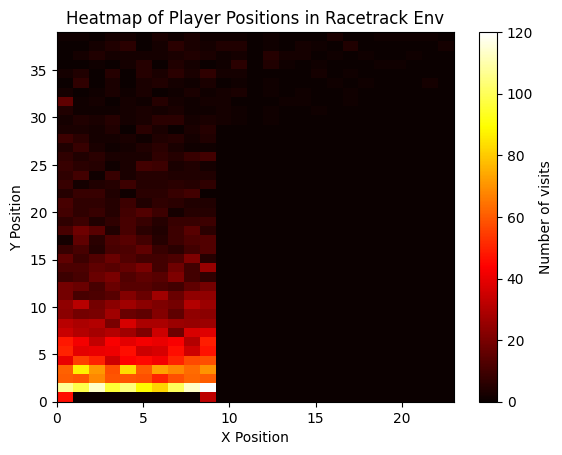

In [82]:
# plot a heatmap of positions
import matplotlib.pyplot as plt

x_vals = [pos[0] for pos in positions]
y_vals = [pos[1] for pos in positions]
plt.hist2d(x_vals, y_vals, bins=[env.x_max, env.y_max], cmap='hot')
plt.colorbar(label="Number of visits")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Heatmap of Player Positions in Racetrack Env")
plt.show()

## Environment 2 – a chase. 


In [83]:
import math
import random


class ChaseEnv:
    def __init__(self, config):
        self.n = config["length"]
        self.pred_step_size = config["predator_step_size"]
        self.base_pos = (self.n - 1, self.n - 1)

        self.action_space = [(dx, dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1]]

        self.reset()

    def reset(self, seed=None):
        # reset positions
        self.player_pos = (0, 0)
        self.pred_pos = (random.randint(0, self.n - 1), random.randint(0, self.n - 1))
        # reset velocities
        self.player_vel = (0, 0)

    def __bound(self, val, min_val, max_val):
        return max(min_val, min(val, max_val))

    def __move_player(self, acceleration):
        # a = 0.5 to 1.5 * action acceleration
        stochastic_fun = lambda x: x * (random.random() + 0.5)
        stochastic_accel = (
            stochastic_fun(acceleration[0]),
            stochastic_fun(acceleration[1]),
        )

        # apply acceleration with bounds
        self.player_vel = (
            self.__bound(self.player_vel[0] + stochastic_accel[0], -5, 5),
            self.__bound(self.player_vel[1] + stochastic_accel[1], -5, 5),
        )
        # update position with bounds
        self.player_pos = (
            self.__bound(self.player_pos[0] + self.player_vel[0], 0, self.n - 1),
            self.__bound(self.player_pos[1] + self.player_vel[1], 0, self.n - 1),
        )

    def __move_predator(self):
        # move towards player
        dx = self.player_pos[0] - self.pred_pos[0]
        dy = self.player_pos[1] - self.pred_pos[1]
        # normalize and scale to step size
        dist = math.hypot(dx, dy)
        dx = (dx / dist) * self.pred_step_size if dist != 0 else 0
        dy = (dy / dist) * self.pred_step_size if dist != 0 else 0
        # update predeator position
        self.pred_pos = (
            self.__bound(self.pred_pos[0] + dx, 0, self.n - 1),
            self.__bound(self.pred_pos[1] + dy, 0, self.n - 1),
        )

    def step(self, action):
        # get new player velocity
        if 0 > action or action >= len(self.action_space):
            raise ValueError("Invalid action")

        # update positions w/ random who goes first
        if random.random() < 0.5:
            self.__move_player(self.action_space[action])
            if math.dist(self.player_pos, self.base_pos) < 0.5:
                return {
                    "state": [self.player_pos, self.player_vel, self.pred_pos],
                    "r": 10,
                    "done": True,
                }
            self.__move_predator()
            if math.dist(self.pred_pos, self.player_pos) < 0.01:
                return {
                    "state": [self.player_pos, self.player_vel, self.pred_pos],
                    "r": -10,
                    "done": True,
                }
        else:
            self.__move_predator()
            if math.dist(self.pred_pos, self.player_pos) < 0.01:
                return {
                    "state": [self.player_pos, self.player_vel, self.pred_pos],
                    "r": -10,
                    "done": True,
                }
            self.__move_player(self.action_space[action])
            if math.dist(self.player_pos, self.base_pos) < 0.5:
                return {
                    "state": [self.player_pos, self.player_vel, self.pred_pos],
                    "r": 10,
                    "done": True,
                }
        return {
            "state": [self.player_pos, self.player_vel, self.pred_pos],
            "r": -1,
            "done": False,
        }

    def render(self, past_positions=None):
        # generated using copilot auto-complete
        grid = [["."] * self.n for _ in range(self.n)]
        if past_positions:
            for pos in past_positions:
                grid[int(pos[0][1])][int(pos[0][0])] = "*"
                grid[int(pos[1][1])][int(pos[1][0])] = "o"
        grid[self.base_pos[1]][self.base_pos[0]] = "B"
        grid[int(self.pred_pos[1])][int(self.pred_pos[0])] = "P"
        grid[int(self.player_pos[1])][int(self.player_pos[0])] = "X"
        print("\n".join("".join(row) for row in reversed(grid)))

In [ ]:
config = {
    "length": 10,
    "predator_step_size": 4
}
num_episodes = 1000

env = ChaseEnv(config)
results = []
positions = []
num_wins = 0
for episode in range(num_episodes):
    state = env.reset()
    done = False
    past_positions = []
    total_reward = 0
    while not done:
        action = random.randint(0, len(env.action_space) - 1)
        result = env.step(action)
        state, reward, done = result["state"], result["r"], result["done"]
        past_positions.append((env.player_pos, env.pred_pos))
        total_reward += reward
        positions.append(env.player_pos)
        if done and reward > 1:
            num_wins += 1
    results.append(total_reward)
    # env.render(past_positions)

print(f"Average reward over {num_episodes} episodes: {sum(results) / len(results)}")
print(f"Max reward over {num_episodes} episodes: {max(results)}")
print(f"Number of wins over {num_episodes} episodes: {num_wins} ({num_wins / num_episodes * 100:.2f}%)")

Average reward over 1000 episodes: -13.333
Max reward over 1000 episodes: 7
Number of wins over 1000 episodes: 161 (16.10%)


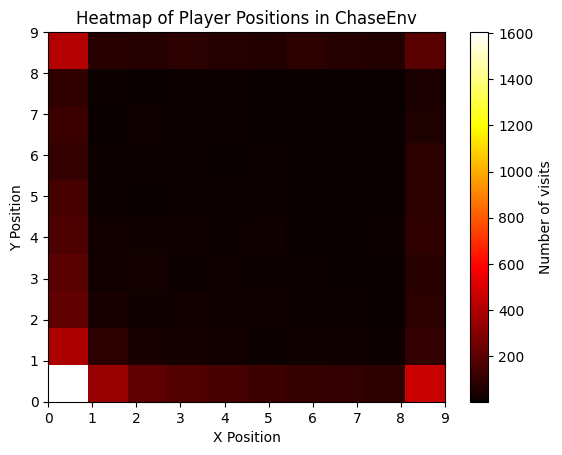

In [85]:
# plot a heatmap of ployer positions
import matplotlib.pyplot as plt

x_vals = [pos[0] for pos in positions]
y_vals = [pos[1] for pos in positions]
plt.hist2d(x_vals, y_vals, bins=[env.n, env.n], cmap="hot")
plt.colorbar(label="Number of visits")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Heatmap of Player Positions in ChaseEnv")
plt.show()